In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# parameters for generating map

In [3]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 10)*1.e9
input_params = [A, alpha, beta, gamma]
#create a filepath to store different power spectra
filepath = '/Users/alex/Documents/foreground_moments/power_spectra/'

# define the input model

In [4]:
in_model = ff.model(ells, freqs, input_params)

# define the 2d data we're going to try to fit

In [5]:
# #make data at 10 freqs and double the nside
# big_mat = np.zeros((100, len(freqs), len(ells)))
# for i in range(100):
#     if i%5 == 0:
#         print('step ' + str(i))
#     big_mat[i] = ff.ps_data(ells, freqs, [A, alpha, beta, gamma])
# np.save(filepath + 'reference_ps_10_freqs.npy', np.mean(big_mat, 0))
    
PS_data = np.load(filepath + 'reference_ps_10_freqs.npy')

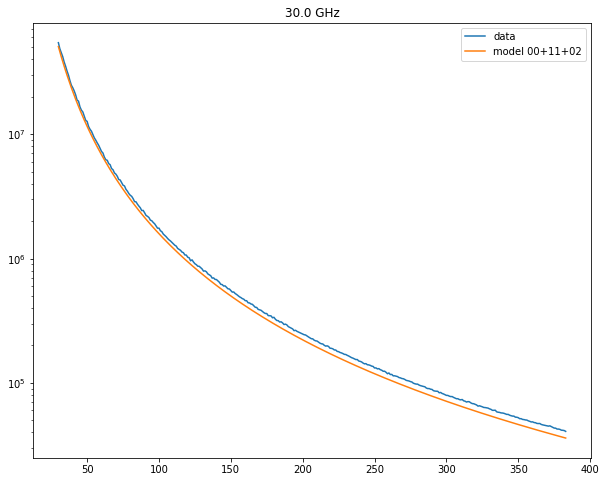

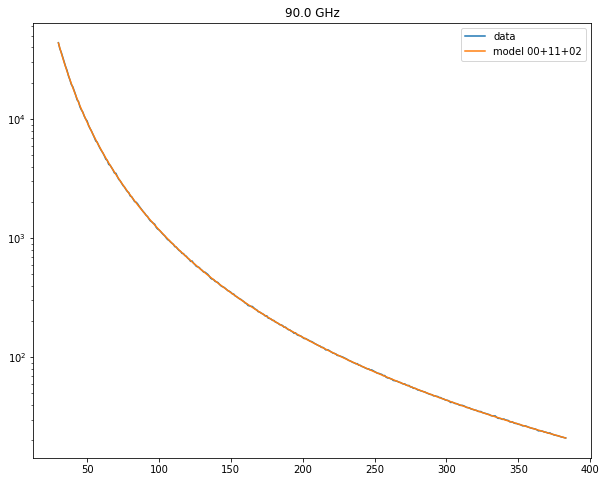

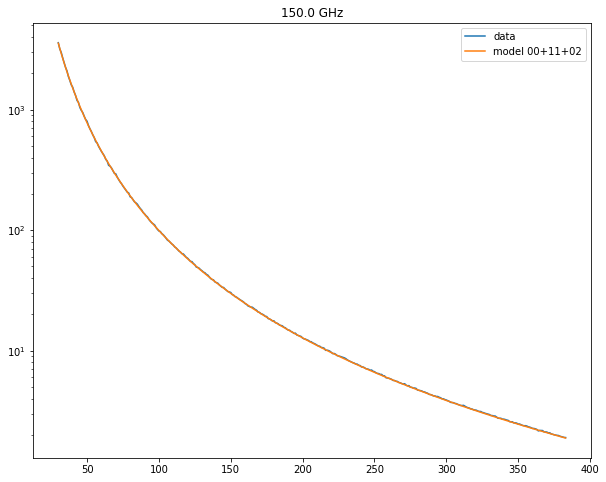

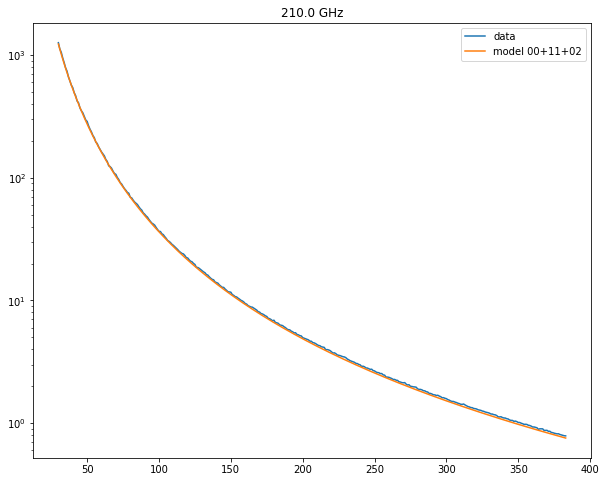

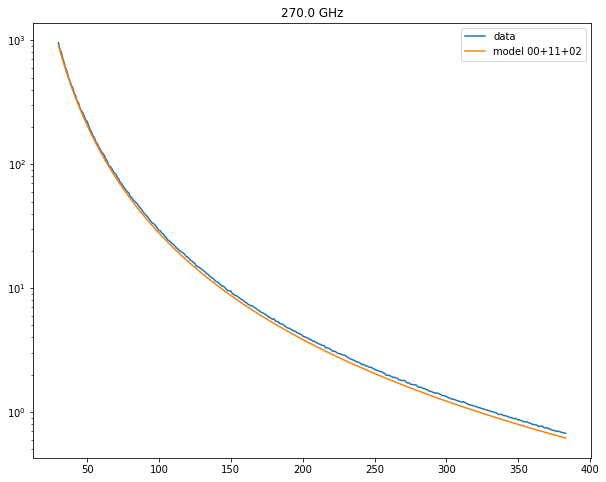

In [8]:
for i in range(len(freqs)):
    if i%2==0: #to reduce number of plots
        figure(figsize=(10,8))
        semilogy(ells[30:], PS_data[i][30:],  label='data')
        semilogy(ells[30:], in_model[i][30:], label='model 00+11+02')
        title(str(np.round(freqs[i]*1e-9)) + ' GHz')
        legend()

# define our objective function (chi2 with cosmic variance) -- we're currently ignoring the high ell cut off by generating both the data and the 1x1 moment with twice the nside and truncating at ell=384. This is a little slower, but avoids having to modify the objective function, which is what we'll probably have to do ultimately

In [9]:
def chi2(params, ells, freqs, data):
    chi2=0
    A, alpha, beta, gamma = params
    model = ff.model(ells, freqs, params)
    
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    
    #don't count the first 30 ell in the objective function.
    chi2 = (data[:,30:] - model[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

In [10]:
start=time.time()
result0 = minimize(chi2, [1e3, -1,-1,-2.8], args=(ells, freqs, PS_data), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-2.8, -2.01)))
print(time.time()-start)
print(result0)

122.57788181304932
      fun: 169.93033465640548
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.70530257e-05, -1.63936420e-02,  1.61207936e-02,  4.61568561e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 370
      nit: 60
   status: 0
  success: True
        x: array([1711.21137828,   -3.01977737,   -3.2054858 ,   -2.45068996])


In [11]:
x0 = result0.x
fit0 = ff.model(ells, freqs, x0)
print(chi2(input_params, ells, freqs, PS_data))
print(chi2(x0, ells, freqs, PS_data))
#so better chi2 value, that's good

#print the relative errors on these fits
print((x0-[A, alpha, beta, gamma])/[A, alpha, beta, gamma]*100)

2788.9517877881963
169.93033465640548
[ 0.65949284  0.65924557  0.1714314  -1.97240158]


In [12]:
#okay, so it's found an effective gamma that varies by 2% from the input value. That's interesting.

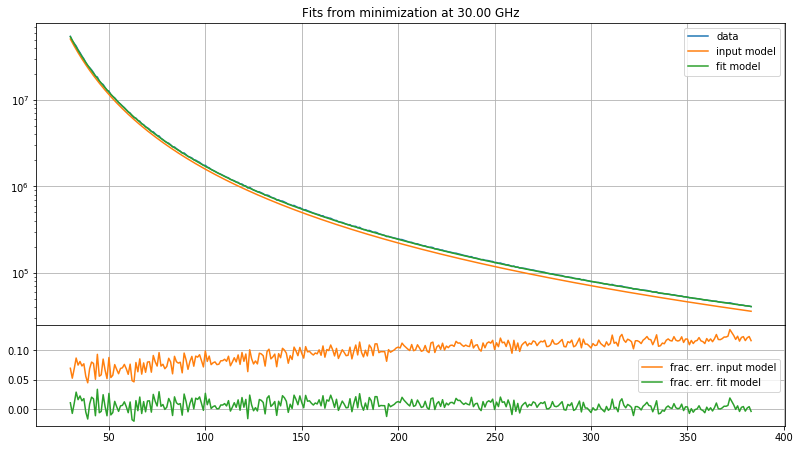

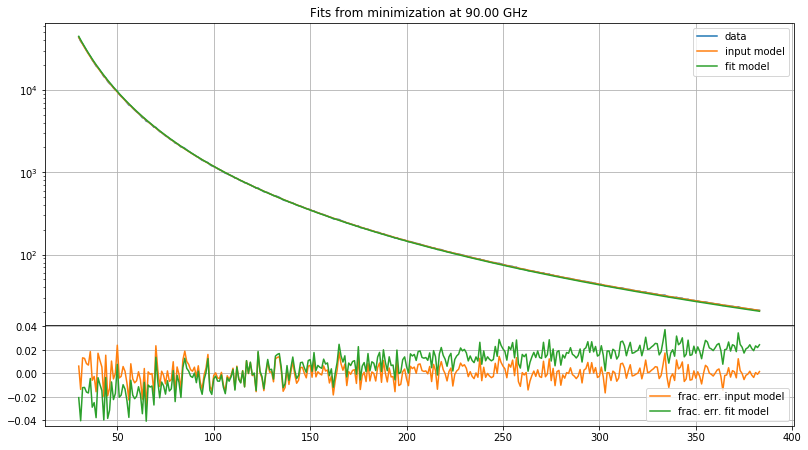

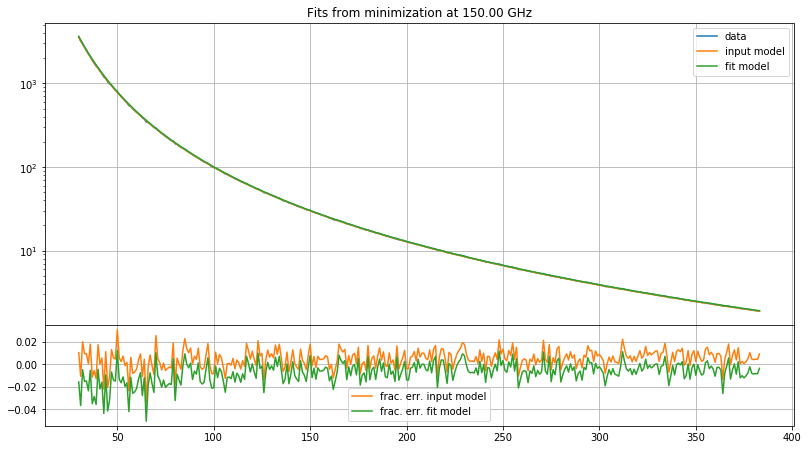

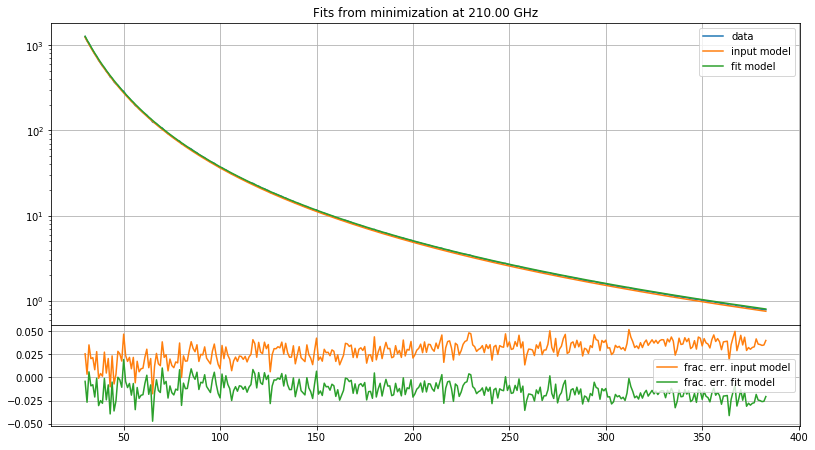

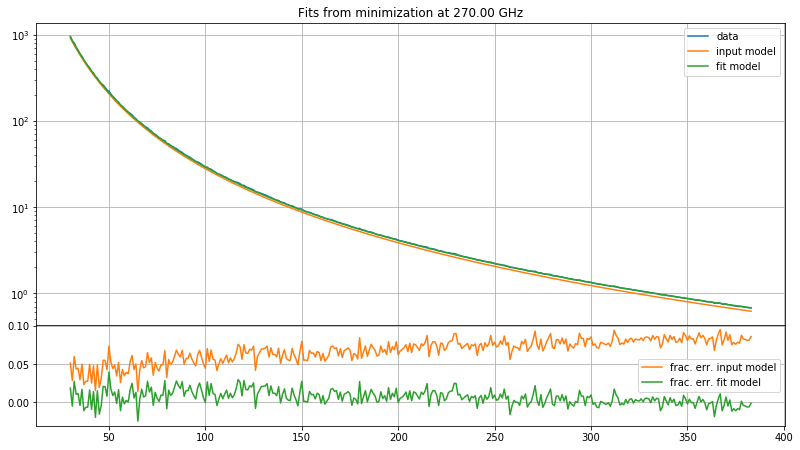

In [13]:
for i in range(len(freqs)):
    if i%2==0: #reduce number of plots
        fig1 = figure(figsize=(13,7))
        frame1=fig1.add_axes((.1,.3,.8,.6))
        frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
        semilogy(ells[30:], PS_data[i][30:], label='data')
        semilogy(ells[30:], in_model[i][30:], label='input model', color='C1')
        semilogy(ells[30:], fit0[i][30:], label='fit model', color='C2')
        grid()
        title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
        legend()



        frame2=fig1.add_axes((.1,.1,.8,.2)) 
        plot(ells[30:], (PS_data[i][30:]-in_model[i][30:])/PS_data[i][30:],
             color='C1', label='frac. err. input model')
        plot(ells[30:], (PS_data[i][30:]-fit0[i][30:])/PS_data[i][30:],
             color='C2', label='frac. err. fit model')
        legend()
        grid()


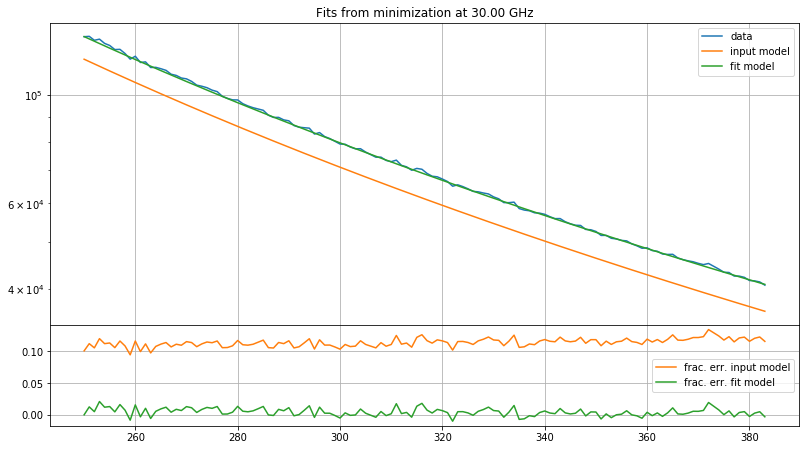

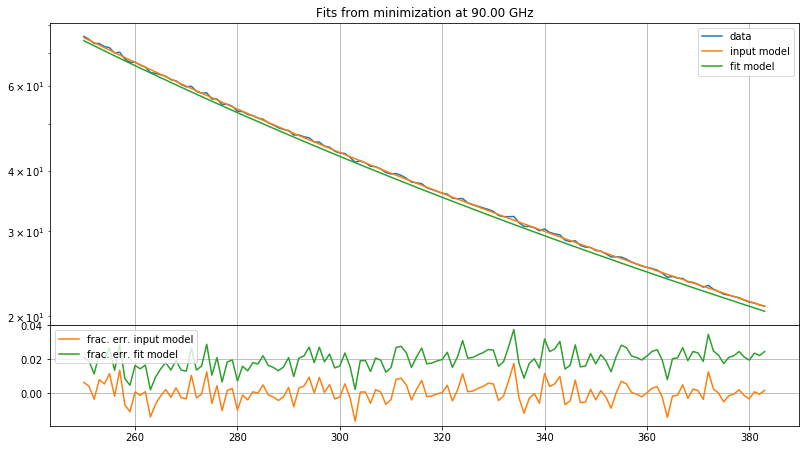

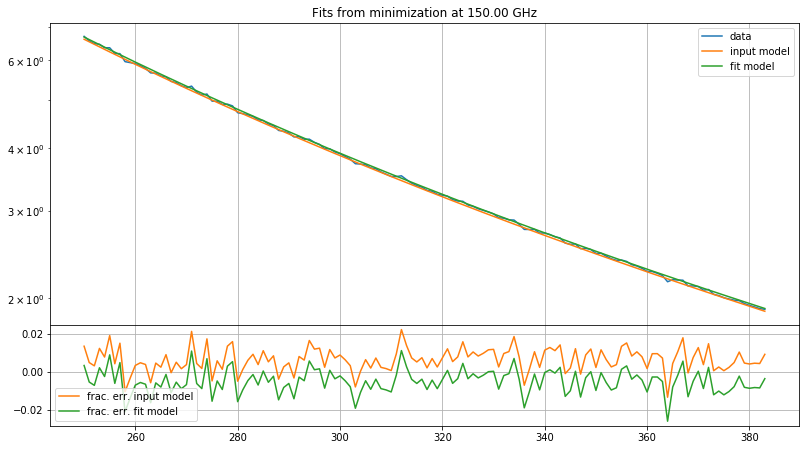

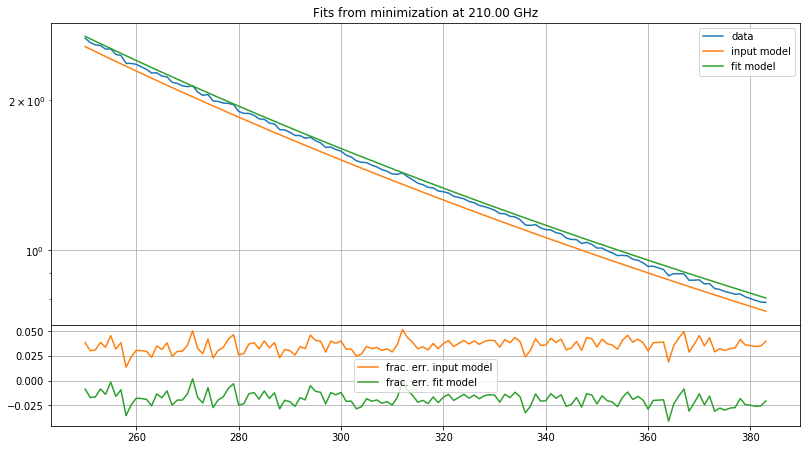

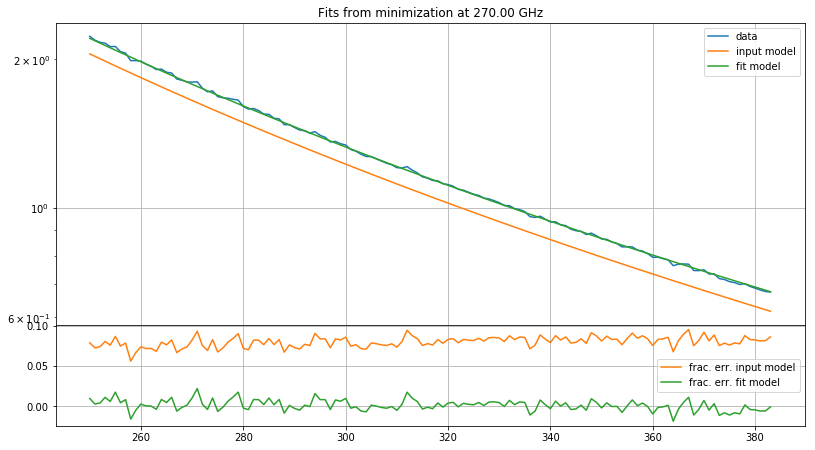

In [14]:
for i in range(len(freqs)):
    if i%2 == 0: #just reduce the number of plots
        fig1 = figure(figsize=(13,7))
        frame1=fig1.add_axes((.1,.3,.8,.6))
        frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
        semilogy(ells[250:], PS_data[i][250:], label='data')
        semilogy(ells[250:], in_model[i][250:], label='input model', color='C1')
        semilogy(ells[250:], fit0[i][250:], label='fit model', color='C2')
        grid()
        title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
        legend()



        frame2=fig1.add_axes((.1,.1,.8,.2)) 
        plot(ells[250:], (PS_data[i][250:]-in_model[i][250:])/PS_data[i][250:], 
             color='C1', label='frac. err. input model')
        plot(ells[250:], (PS_data[i][250:]-fit0[i][250:])/PS_data[i][250:],
             color='C2', label='frac. err. fit model')
        legend()
        grid()


# let's see what happens if we fit just a single realisation of the power spectrum

In [15]:
%autoreload

In [16]:
ps_single = ff.ps_data(ells, freqs, [A, alpha, beta, gamma])

In [17]:
%timeit ff.ps_data(ells, freqs, input_params)

12.1 s ± 779 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
start=time.time()
result1 = minimize(chi2, [1e3, -1,-1,-2.8], args=(ells, freqs, ps_single), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-2.8, -2.01)))
print(time.time()-start)
print(result1)

119.2082769870758
      fun: 3796.725719189093
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00013642, -0.02082743,  0.05866241,  0.10877557])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 370
      nit: 60
   status: 0
  success: True
        x: array([1746.21570881,   -3.03849041,   -3.1807638 ,   -2.47353925])


In [19]:
x1 = result1.x
fit1 = ff.model(ells, freqs, x1)
#print the fractional change from the input parameters
print((x1-[A, alpha, beta, gamma])/[A, alpha, beta, gamma]*100)

[ 2.71857111  1.28301377 -0.60113112 -1.05843013]


In [115]:
#so single realisation returns basically the same parameters as the averaged (e.g. the effective gamma is noticable
#even with just one realisation, and there's also an effecive A, probably a degeneracy there). 
#Obvisously the errors on these parameters will be larger than the averaged case, but still, this is good. We can
#fit the parameters even with only one realisation.

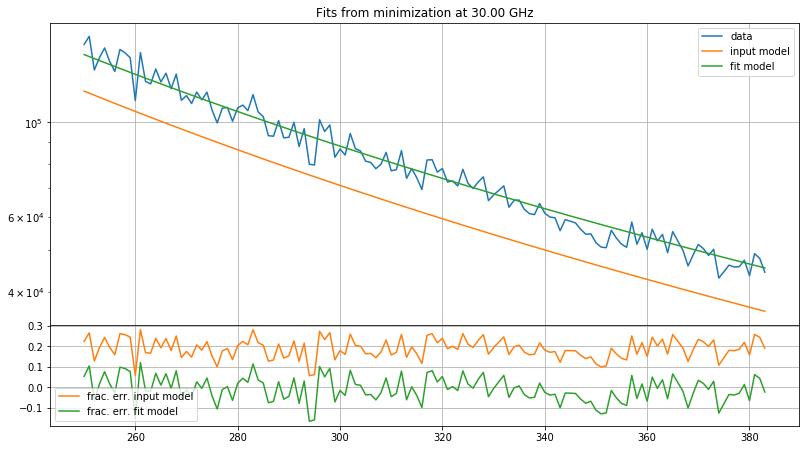

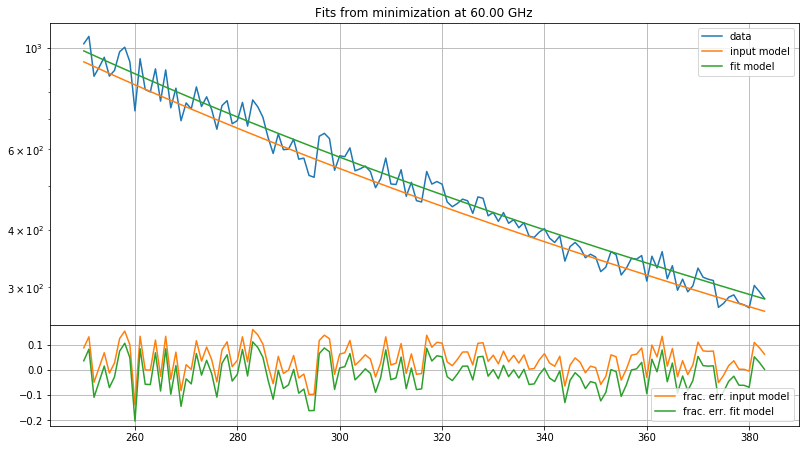

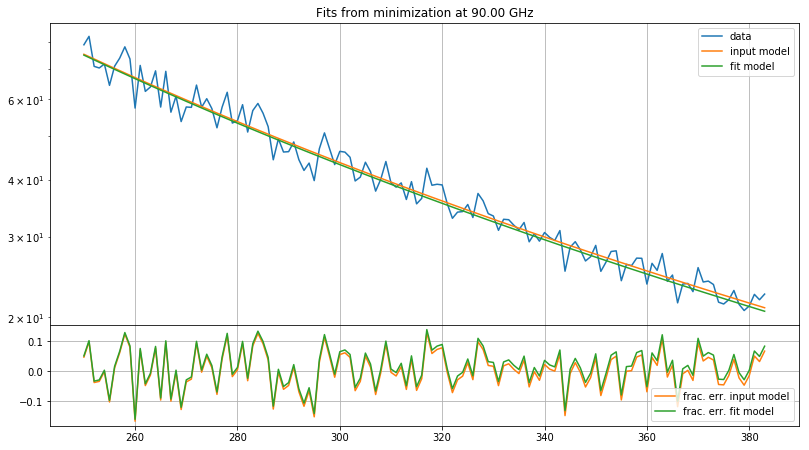

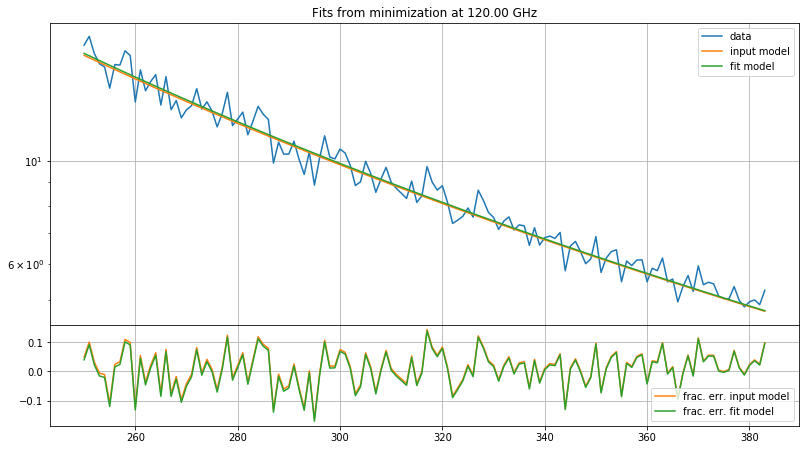

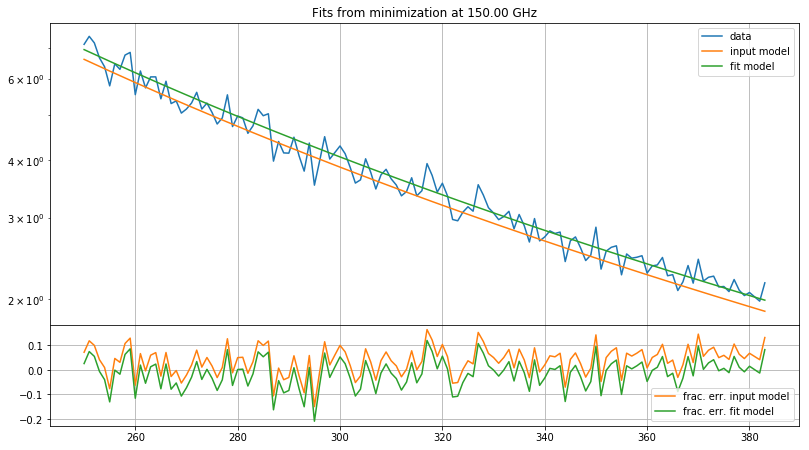

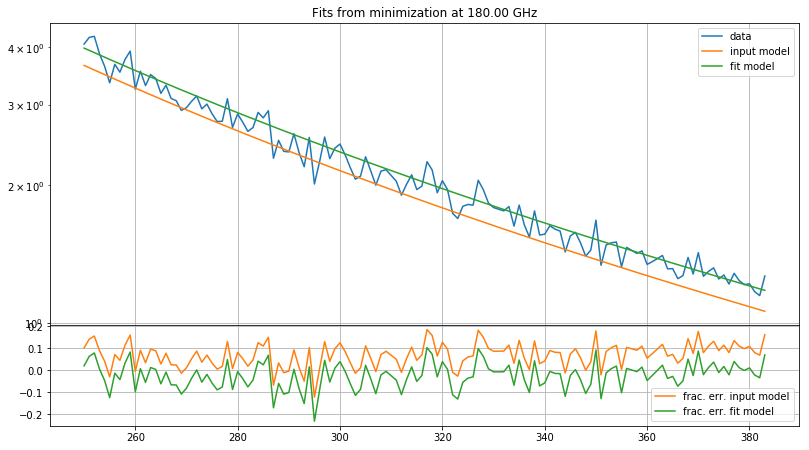

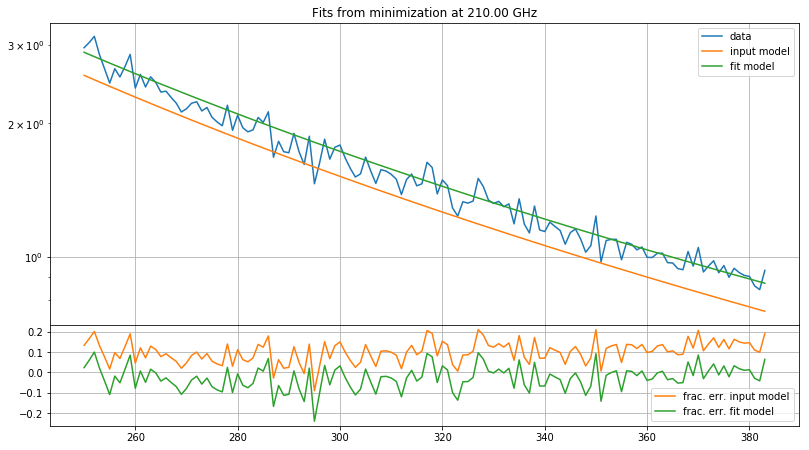

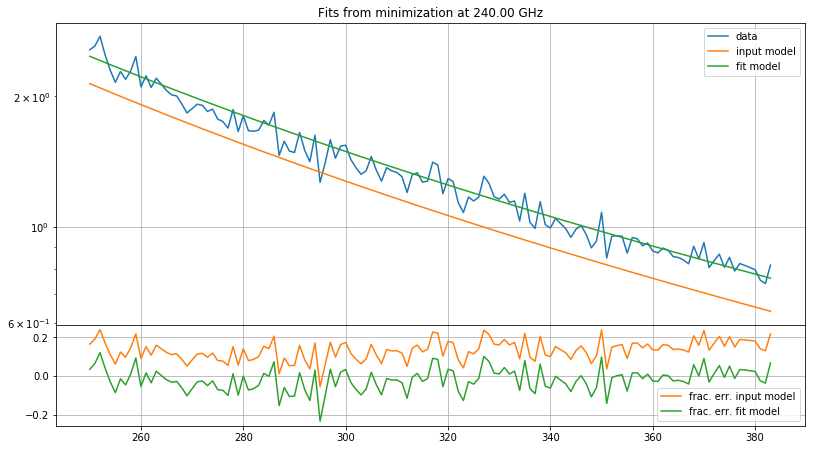

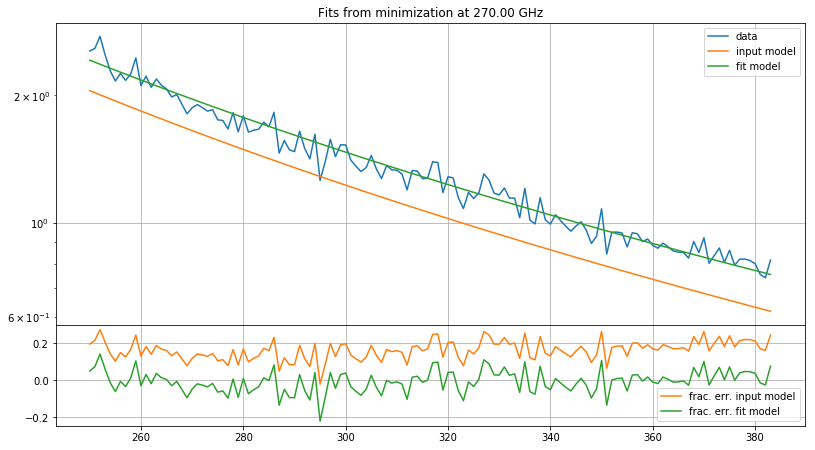

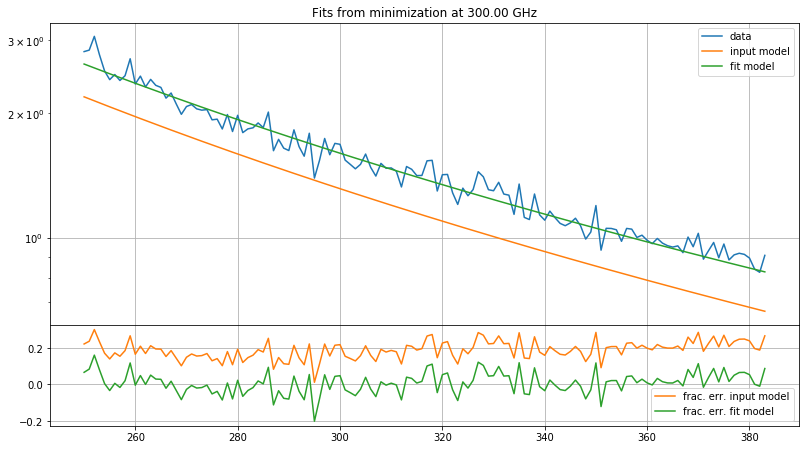

In [83]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[250:], ps_single[i][250:], label='data')
    semilogy(ells[250:], in_model[i][250:], label='input model', color='C1')
    semilogy(ells[250:], fit1[i][250:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[250:], (ps_single[i][250:]-in_model[i][250:])/ps_single[i][250:], color='C1', label='frac. err. input model')
    plot(ells[250:], (ps_single[i][250:]-fit1[i][250:])/ps_single[i][250:], color='C2', label='frac. err. fit model')
    legend()
    grid()


# Let's see if the effective gamma shows up with a different set of parameters

In [85]:
#define a second set of parameters
param1 = [1.3e3, -3.2, -3.5, -3.0]
in_model1 = ff.model(ells, freqs, param1)

In [86]:
ps_single1 = ff.ps_data(ells, freqs, param1)

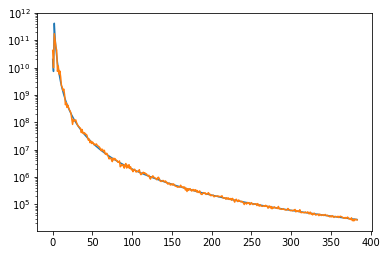

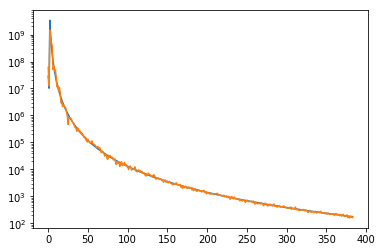

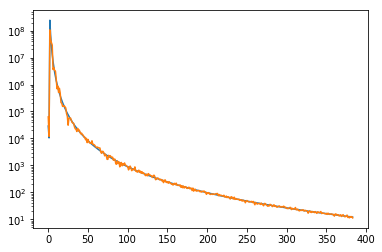

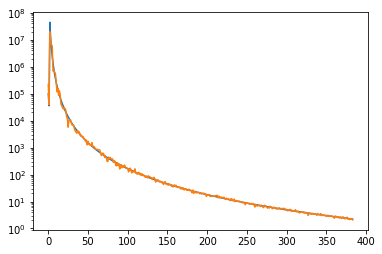

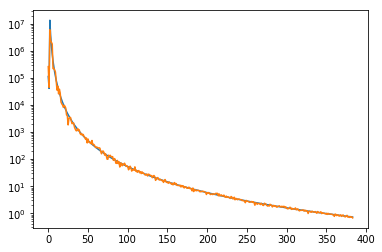

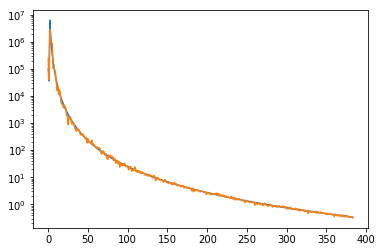

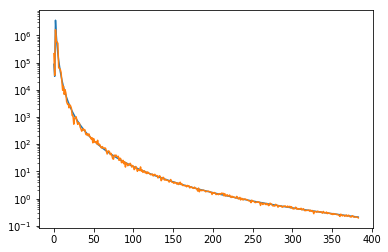

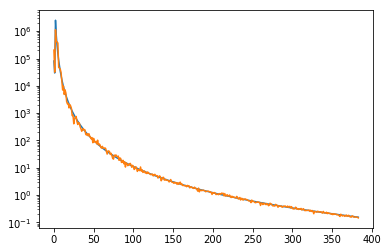

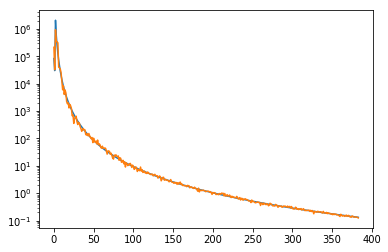

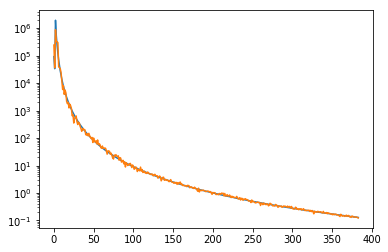

In [87]:
for i in range(len(freqs)):
    figure()
    semilogy(in_model1[i])
    semilogy(ps_single1[i])

In [88]:
start=time.time()
result2 = minimize(chi2, [1e3, -1,-1,-2.8], args=(ells, freqs, ps_single1), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-3.5, -2.01)))
print(time.time()-start)
print(result2)

119.13693404197693
      fun: 3726.865708341934
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.54747351e-05,  1.05956133e-02,  1.32331479e-02, -2.72848411e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 290
      nit: 53
   status: 0
  success: True
        x: array([1323.79189628,   -3.21701024,   -3.49981588,   -3.00772632])


In [90]:
x2 = result2.x
print((param1 - x2)/x2*100)

[-1.79725351 -0.5287592   0.00526076 -0.25688232]


In [102]:
#interesting, so here it's found an effective amplitude more than an effective gamma. I wonder if this changes 
#based on realisation of the data or not.

In [104]:
ps_single2 = ff.ps_data(ells, freqs, param1)

In [105]:
start=time.time()
result3 = minimize(chi2, [1e3, -1,-1,-2.8], args=(ells, freqs, ps_single2), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-3.5, -2.01)))
print(time.time()-start)
print(result3)

120.52374076843262
      fun: 3712.2226211329566
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.68256520e-03, 8.20409696e-01, 3.18586899e+00, 1.19421202e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 270
      nit: 47
   status: 0
  success: True
        x: array([1319.30203943,   -3.22005542,   -3.50206146,   -2.92199657])


In [106]:
x3 = result3.x
print((param1 - x3)/x3*100)

[-1.46304931 -0.62282836 -0.05886415  2.6695249 ]


In [108]:
#okay, so whether the effective parameter is gamma or the amplitude seems to be a realisation effect, as these
#two fits were done on data generated with the same parameter, but they have different fractional errors
#on the A and gamma parameters. Should get errors on these parameter fits eventually (MCMC)